In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import pickle

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# Any results you write to the current directory are saved as output.

/kaggle/input/products.csv
/kaggle/lib/kaggle/gcp.py
/kaggle/input/products.csv
/kaggle/working/finalized_model.sav
/kaggle/working/__notebook_source__.ipynb


In [5]:
recipes=pd.read_csv('/kaggle/input/products.csv', 
                 names=['Text','t1','t2','t3'],
                 skiprows=1,
                 sep='|')
recipes.head()

,Text,t1,t2,t3
0,"Давным давно, когда армия еще была Советской, ...",Горячие блюда,Блюда из мяса,Горячие блюда с колбасными изделиями
1,Булки-зайцы сделала из постного теста на помид...,Выпечка,Изделия из теста,Булочки
2,Мягкие и невероятно вкусные рулетики из творож...,Выпечка,Изделия из теста,Рулеты
3,"Очень вкусные, сочные, сытные и несложные в пр...",Выпечка,Изделия из теста,Пироги
4,Испечённый в духовке кекс с тонким ароматом и ...,Выпечка,Изделия из теста,Кексы


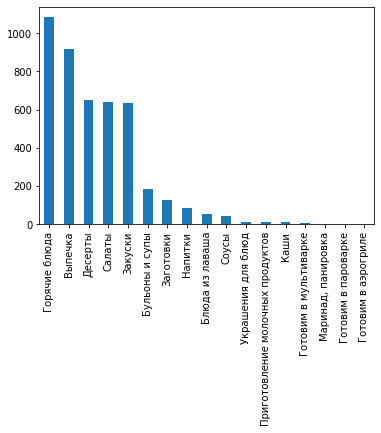

In [82]:
recipes.t1.value_counts().plot(kind='bar')

In [8]:
recipes.Text[2]

'Мягкие и невероятно вкусные рулетики из творожного теста. Их очень легко и быстро можно приготовить из доступных продуктов. Это не займёт много времени. Приготовьте и Вам обязательно понравится. Приятного аппетита.'

In [17]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^а-яА-ЯЁё]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [18]:
recipes.clean_text = recipes.Text.apply(lambda x: clean_text(x))
recipes.clean_text[2]

'мягкие и невероятно вкусные рулетики из творожного теста их очень легко и быстро можно приготовить из доступных продуктов это не займёт много времени приготовьте и вам обязательно понравится приятного аппетита'

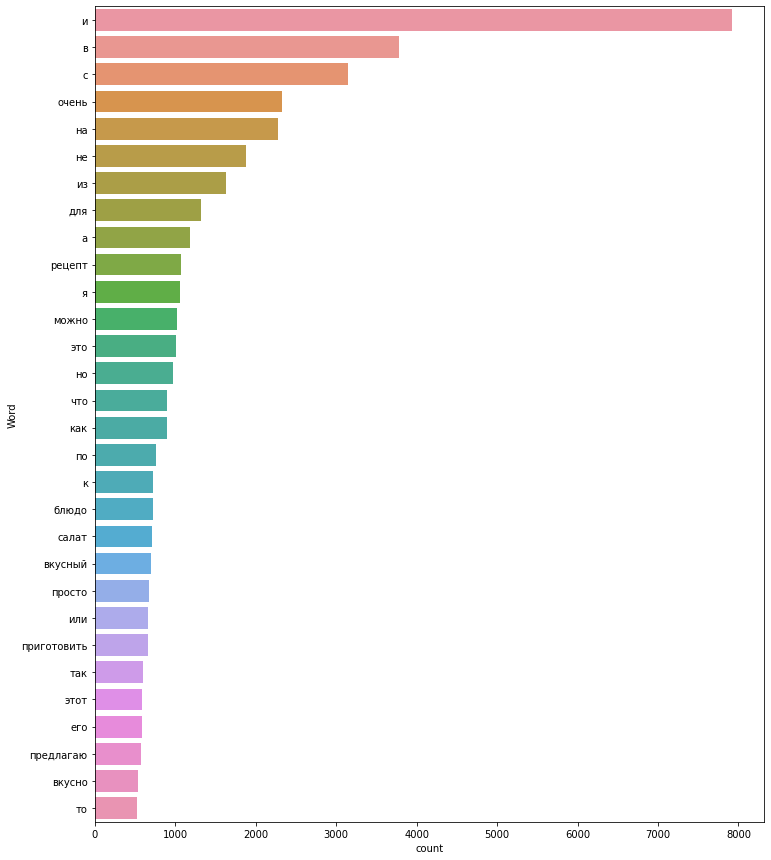

In [20]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(recipes.clean_text, 30)

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

recipes.clean_text = recipes.clean_text.apply(lambda x: remove_stopwords(x))

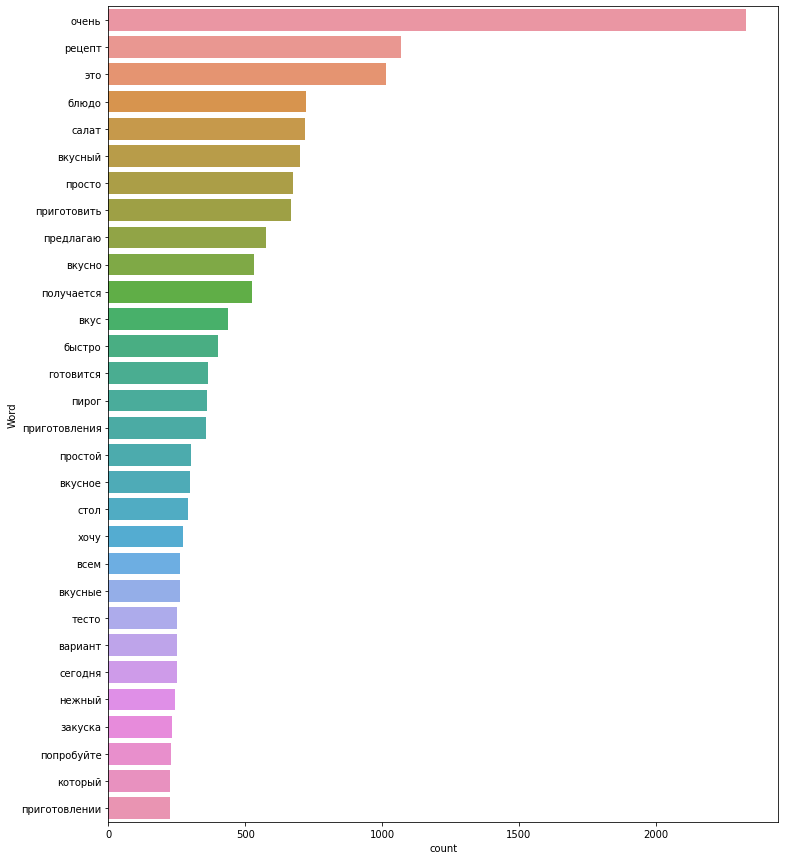

In [24]:
freq_words(recipes.clean_text, 30)

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [27]:
xtrain, xval, ytrain, yval = train_test_split(recipes.clean_text, recipes.t1, test_size=0.2, random_state=9)

In [30]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [34]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [35]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [36]:
y_pred = clf.predict(xval_tfidf)

In [39]:
f1_score(yval, y_pred, average="micro")

0.7472035794183445

In [41]:
y_pred

array(['Десерты', 'Горячие блюда', 'Выпечка', 'Выпечка', 'Десерты',
       'Десерты', 'Горячие блюда', 'Горячие блюда', 'Салаты', 'Выпечка',
       'Горячие блюда', 'Выпечка', 'Выпечка', 'Закуски', 'Салаты',
       'Десерты', 'Горячие блюда', 'Горячие блюда', 'Бульоны и супы',
       'Выпечка', 'Горячие блюда', 'Выпечка', 'Салаты', 'Выпечка',
       'Выпечка', 'Салаты', 'Горячие блюда', 'Салаты', 'Десерты',
       'Салаты', 'Салаты', 'Выпечка', 'Горячие блюда', 'Закуски',
       'Горячие блюда', 'Десерты', 'Горячие блюда', 'Горячие блюда',
       'Горячие блюда', 'Салаты', 'Закуски', 'Десерты', 'Горячие блюда',
       'Горячие блюда', 'Горячие блюда', 'Горячие блюда', 'Салаты',
       'Выпечка', 'Горячие блюда', 'Салаты', 'Десерты', 'Салаты',
       'Горячие блюда', 'Десерты', 'Горячие блюда', 'Горячие блюда',
       'Горячие блюда', 'Выпечка', 'Салаты', 'Десерты', 'Выпечка',
       'Горячие блюда', 'Горячие блюда', 'Горячие блюда', 'Горячие блюда',
       'Выпечка', 'Горячие блюда', '

In [43]:
xval

4348    странно многие хозяюшки предпочитают готовить ...
3160    всем привет друзья предлагаю вашему вниманию р...
56      тесто готовится дрожжей начинку использовать л...
1876    очень простой вкусный мармелад киви апельсинов...
3239    нашей семье очень любят овсяное печенье пряный...
                              ...                        
502     знаю одного человека который любил шашлык кажд...
485     перебирая новым годом коллекцию рецептов натол...
2148    наш ответ западному чизкейку нежное воздушное ...
2760    быстрые простые рецепты будние дни думаю незам...
3206    серьёзный салат жареной говядиной разными перц...
Name: Text, Length: 894, dtype: object

In [61]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return q_pred

In [55]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Text: ", recipes.Text[k], 
        "\nPredicted text: ", 
        infer_tags(xval[k])), print("Actual genre: ",recipes.t1[k], "\n")

Text:  Баклажаны с такой начинкой получаются очень вкусные и сытные. Эту закуску можно также использовать как салат. Вечером - овощи, утром - закуска ( салат). 
Predicted text:  ['Салаты']
Actual genre:  Закуски 

Text:  Лучший рецепт популярного торта "Медовик", этот рецепт давно используется в моей семье, и я хочу им поделиться с вами. 
Predicted text:  ['Десерты']
Actual genre:  Десерты 

Text:  Рецепт этого кекса родом из Италии, правда пекут они его строго в форме кольца. Меня рецепт привлек красотой и простотой. Формочка у меня праздничная. 
Predicted text:  ['Горячие блюда']
Actual genre:  Выпечка 

Text:  Дорогие друзья, хочу познакомить Вас с старинным украинским блюдом, относящимся к лемковской кухне. Это название происходит от слова "бандура" и на диалекте лемков не что иное как картошка. Это разновидность дерунов, драников залитые сметано-грибным соусом и запечённые в духовке. Это очччень вкусно... и совершенно не сложно!!! 
Predicted text:  ['Горячие блюда']
Actual genre: 

In [90]:
infer_tags(' ')

array(['Горячие блюда'], dtype='<U32')

In [91]:
clf

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [94]:
filename = 'finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [104]:
loaded_model = pickle.load(open('/kaggle/working/finalized_model.sav', 'rb'))

In [106]:
def infer_tags2(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = loaded_model.predict(q_vec)
    return q_pred
infer_tags2('привет')

array(['Выпечка'], dtype='<U32')